# Bicycle Theft Prediction - Feature Engineering

## 1. Import Dependencies

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark')
sns.set_palette('husl')

## 2. Load Data and Check Initial Distribution

In [9]:
# Load the data
df = pd.read_csv('../data/Bicycle_Thefts_Data.csv')

print("Class Distribution:")
print(df['STATUS'].value_counts(normalize=True))

Class Distribution:
STATUS
STOLEN       0.973129
UNKNOWN      0.016408
RECOVERED    0.010463
Name: proportion, dtype: float64


## 3. Feature Engineering Functions

In [10]:
def preprocess_features(df):
    df = df.copy()
    df['OCC_DATE'] = pd.to_datetime(df['OCC_DATE'])
    df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])
    df['OCC_HOUR_BIN'] = pd.cut(df['OCC_HOUR'],
                               bins=[-1,6,12,18,24],
                               labels=['Night','Morning','Afternoon','Evening']).astype(str)

    month = pd.to_datetime(df['OCC_DATE']).dt.month
    conditions = [
        (month >= 3) & (month <= 5),
        (month >= 6) & (month <= 8),
        (month >= 9) & (month <= 11)
    ]
    choices = ['Spring', 'Summer', 'Fall']
    df['SEASON'] = np.select(conditions, choices, default='Winter')

    conditions = [
        df['BIKE_COST'].astype(float) <= 500,
        (df['BIKE_COST'].astype(float) > 500) & (df['BIKE_COST'].astype(float) <= 1000),
        (df['BIKE_COST'].astype(float) > 1000) & (df['BIKE_COST'].astype(float) <= 2000),
        (df['BIKE_COST'].astype(float) > 2000) & (df['BIKE_COST'].astype(float) <= 5000)
    ]
    choices = ['Very Low', 'Low', 'Medium', 'High']
    df['COST_CATEGORY'] = np.select(conditions, choices, default='Very High')

    df['x'] = np.cos(2 * np.pi * df['OCC_DOY'] / 365)
    df['y'] = np.sin(2 * np.pi * df['OCC_DOY'] / 365)

    df['IS_NIGHT'] = ((df['OCC_HOUR'] >= 20) | (df['OCC_HOUR'] <= 5)).astype(int)
    df['IS_WEEKEND'] = df['OCC_DOW'].isin(['Saturday', 'Sunday']).astype(int)

    df['OCC_DAY'] = pd.to_datetime(df['OCC_DATE']).dt.day
    df['OCC_YEAR'] = pd.to_datetime(df['OCC_DATE']).dt.year
    df['REPORT_DAY'] = pd.to_datetime(df['REPORT_DATE']).dt.day

    df['BIKE_SPEED'] = pd.to_numeric(df['BIKE_SPEED'], errors='coerce').fillna(0)
    df['BIKE_COST'] = pd.to_numeric(df['BIKE_COST'], errors='coerce').fillna(0)

    return df

## 4. Process and Encode Features

In [11]:
df_processed = preprocess_features(df)

categorical_columns = [
    'BIKE_MAKE', 'BIKE_MODEL', 'BIKE_TYPE', 'BIKE_COLOUR',
    'PREMISES_TYPE', 'OCC_DOW', 'LOCATION_TYPE',
    'HOOD_140', 'NEIGHBOURHOOD_140', 'OCC_HOUR_BIN',
    'SEASON', 'COST_CATEGORY'
]

# Fill missing categorical values and encode
for col in categorical_columns:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna('Unknown')
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))

## 5. Feature Analysis


Feature Statistics:
         BIKE_SPEED      BIKE_COST      OCC_HOUR       OCC_DOW       OCC_DOY  \
count  37178.000000   37178.000000  37178.000000  37178.000000  37178.000000   
mean      13.672172     933.088245     13.292619      2.992253    199.930766   
std       10.825120    1560.900782      6.526714      2.027103     77.454583   
min        0.000000       0.000000      0.000000      0.000000      1.000000   
25%        3.000000     300.000000      9.000000      1.000000    149.000000   
50%       12.000000     600.000000     14.000000      3.000000    203.000000   
75%       21.000000    1033.454956     18.000000      5.000000    257.000000   
max       99.000000  120000.000000     23.000000      6.000000    366.000000   

            OCC_DAY      OCC_YEAR    REPORT_DAY     BIKE_MAKE    BIKE_MODEL  \
count  37178.000000  37178.000000  37178.000000  37178.000000  37178.000000   
mean      15.645382   2018.718436     15.979881    739.636371   7724.718839   
std        8.637666  

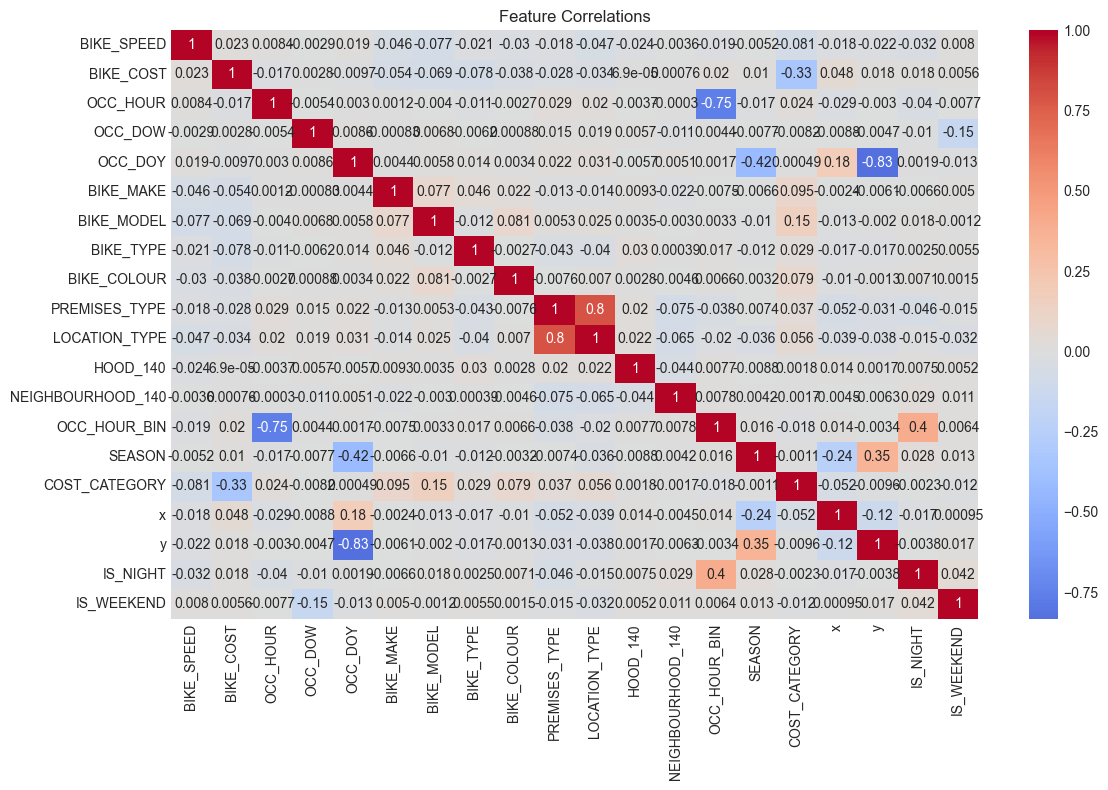

In [12]:
# List of final features
feature_columns = [
    'BIKE_SPEED', 'BIKE_COST', 'OCC_HOUR', 'OCC_DOW',
    'OCC_DOY', 'OCC_DAY', 'OCC_YEAR', 'REPORT_DAY',
    'BIKE_MAKE', 'BIKE_MODEL', 'BIKE_TYPE', 'BIKE_COLOUR',
    'PREMISES_TYPE', 'LOCATION_TYPE', 'HOOD_140',
    'NEIGHBOURHOOD_140', 'OCC_HOUR_BIN', 'SEASON',
    'COST_CATEGORY', 'x', 'y', 'IS_NIGHT', 'IS_WEEKEND'
]

# Display feature statistics
print("\nFeature Statistics:")
print(df_processed[feature_columns].describe())

# Plot correlation matrix for numerical features
numerical_features = df_processed[feature_columns].select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_processed[numerical_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

## 6. Save Processed Features

In [13]:
# Select final features in consistent order
final_features = df_processed[feature_columns]

# Save processed features for later use
final_features.to_csv('../data/processed_features.csv', index=False)
print("\nProcessed features saved to '../data/processed_features.csv'")


Processed features saved to '../data/processed_features.csv'
